<a href="https://colab.research.google.com/github/Frans-Grau/P5-Forecasting/blob/main/M_alldata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
### Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from statsmodels.tsa.arima.model import ARIMA

In [ ]:
### Load the Datasets
#originalyy downloaded from https://www.kaggle.com/datasets/sherrytp/airline-delay-analy
df2016 = pd.read_csv('https://raw.githubusercontent.com/Frans-Grau/Datasets/main/P5%20-%20Datasets/df2016.csv')
df2017 = pd.read_csv('https://raw.githubusercontent.com/Frans-Grau/Datasets/main/P5%20-%20Datasets/df2017.csv')
df2018 = pd.read_csv('https://raw.githubusercontent.com/Frans-Grau/Datasets/main/P5%20-%20Datasets/df2018.csv')

### Quick preprocessing
df_all = pd.concat([df2016,df2017,df2018], ignore_index = True, axis = 0)
df_all.drop(['Unnamed: 0','CANCELLED','DIVERTED'], axis=1, inplace= True)
df_all.dropna(inplace=True)
df_all['FL_DATE'] = pd.to_datetime(df_all['FL_DATE'])
df_all['AIRLINE'] = df_all['OP_CARRIER'].apply(lambda x: 'Delta Airlines' if x == 'DL' else 'Southwest Airlines' if x=='WN' else 'American Airlines' if x=='AA'
else 'JetBlue Airways' if x=='B6' else 'SkyWest Airlines' if x=='OO' else 'Atlantic Southeast Airlines' if x == 'EV' else 'United Airlines' if x == 'UA'
else 'Pinnacle Airlines' if x == '9E' else 'Spirit Airlines' if x== 'NK' else 'Alaska Airlines' if x == 'AS' else 'Virgin America' if x == 'VX' else 'Frontier' if x =='F9'
else 'Republic Airlines' if x == 'YX'else 'Hawaiian Airlines' if x == 'HA' else 'Envoy Air' if x == 'MQ' else 'Air Shuttle' if x == 'YV' else 'Allegiant Air' if x=='G4'
else 'Comair')
df_all.head()

,FL_DATE,OP_CARRIER,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_TIME,AIR_TIME,DISTANCE,AIRLINE
0,2016-01-01,DL,ATL,GRR,2125,2130.0,5.0,2321,2319.0,92.0,640.0,Delta Airlines
1,2016-01-01,DL,LAX,ATL,2255,2256.0,1.0,600,547.0,207.0,1947.0,Delta Airlines
2,2016-01-01,DL,ATL,BNA,1233,1356.0,83.0,1239,1402.0,38.0,214.0,Delta Airlines
3,2016-01-01,DL,ATL,JAX,945,946.0,1.0,1050,1053.0,45.0,270.0,Delta Airlines
4,2016-01-01,DL,ATL,OKC,2110,2107.0,-3.0,2236,2224.0,116.0,761.0,Delta Airlines


##1) EDA

#1.1) General EDA

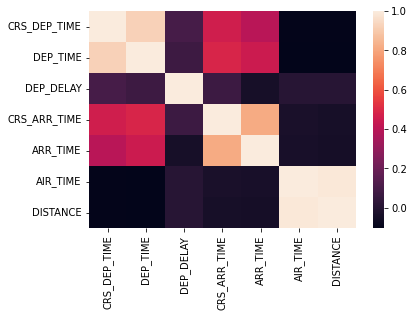

In [ ]:
#check correlations
sns.heatmap(df_all.corr())

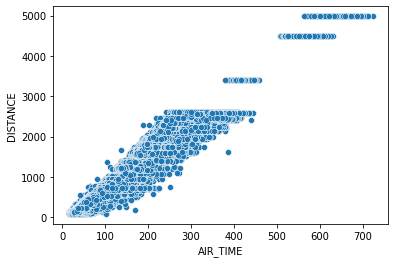

In [ ]:
#see better the corr between distance and air time
sns.scatterplot(data = df_all, x = 'AIR_TIME', y = 'DISTANCE')

In [ ]:
df_all.info()
#around 2M rows

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2080873 entries, 0 to 2109730
Data columns (total 12 columns):
 #   Column        Dtype         
---  ------        -----         
 0   FL_DATE       datetime64[ns]
 1   OP_CARRIER    object        
 2   ORIGIN        object        
 3   DEST          object        
 4   CRS_DEP_TIME  int64         
 5   DEP_TIME      float64       
 6   DEP_DELAY     float64       
 7   CRS_ARR_TIME  int64         
 8   ARR_TIME      float64       
 9   AIR_TIME      float64       
 10  DISTANCE      float64       
 11  AIRLINE       object        
dtypes: datetime64[ns](1), float64(5), int64(2), object(4)
memory usage: 206.4+ MB


In [ ]:
df_all['FL_DATE'].nunique()/365
#3 years of data as expected (2018, 2017, 2016)

3.0027397260273974

In [ ]:
df_all['OP_CARRIER'].nunique()
#18 airline companies

18

In [ ]:
df_all['ORIGIN'].nunique()
#we only chose 3 top US airlines due to the amount of data (ATL, LAX and JFK)

3

In [ ]:
df_all['DEST'].nunique()
#there are 208 destinies with delays from these 3 airports

208

In [ ]:
df_all[df_all['DEP_DELAY'] > 0]['DEP_DELAY'].count()
#773988 are delays

df_all[df_all['DEP_DELAY'] < 0]['DEP_DELAY'].count()
#1175600 are leaving earlier

1175600

In [ ]:
df_all[df_all['DEP_DELAY'] == 0]['DEP_DELAY'].count()
#131285 are leaving on time

131285

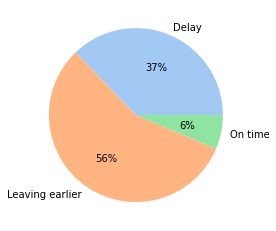

In [ ]:
data = [773988, 1175600, 131285]
labels = ['Delay', 'Leaving earlier', 'On time']
colors = sns.color_palette('pastel')[0:3]
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.show()

In [ ]:
#new pie chart with delay more than and less than 30'

df_all[(df_all['DEP_DELAY'] > 0) & (df_all['DEP_DELAY'] < 30)]['DEP_DELAY'].count()
# 529230 are delays less than 30'

df_all[(df_all['DEP_DELAY'] > 0) & (df_all['DEP_DELAY'] > 30)]['DEP_DELAY'].count()
# 237955 are delays less than 30'

237955

In [ ]:
df_all[(df_all['DEP_DELAY'] < 0) & (df_all['DEP_DELAY'] < -30)]['DEP_DELAY'].count()
# 18 are leaving early more than 30'

df_all[(df_all['DEP_DELAY'] < 0) & (df_all['DEP_DELAY'] > -30)]['DEP_DELAY'].count()
# 1175580 are leaving early less than 30'

1175580

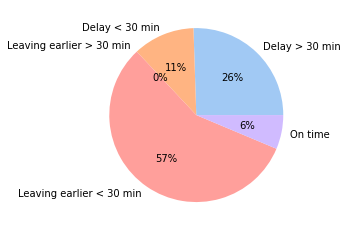

In [ ]:
#this pie chart will not be used because it's confusing
data = [529230, 237955, 18, 1175580, 131285]
labels = ['Delay > 30 min', 'Delay < 30 min', 'Leaving earlier > 30 min', 'Leaving earlier < 30 min', 'On time']
colors = sns.color_palette('pastel')[0:5]
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.show()

In [ ]:
data = {'index' : ['Delay', 'Leaving earlier'], 'Total': [773988	, 1175600], 'Less than 30':[529230, 1175580]}
data = pd.DataFrame(data).set_index('index')
data

# data['Total'][0] = data['Less than 30'][0]/data['Total'][0]
# # data['Leaving earlier'] = data['Leaving earlier'] / data['Leaving earlier'].sum()
# data

,Total,Less than 30
index,,
Delay,773988,529230
Leaving earlier,1175600,1175580


In [ ]:
data['Less than 30'][0]/data['Total'][0]

0.6837702910122637

In [ ]:
1 - data['Less than 30'][0]/data['Total'][0]

0.3162297089877363

In [ ]:
data['Less than 30'][1]/data['Total'][1] #close to 1

1.000016000128001

In [ ]:
1 - data['Less than 30'][1]/data['Total'][1] #close to 0

-1.600012800095918e-05

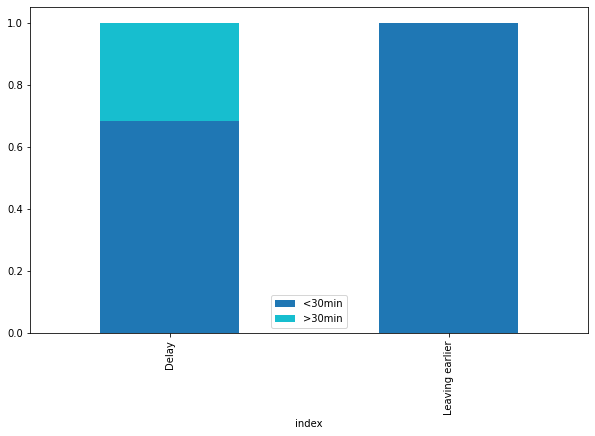

In [ ]:
data = {'index' : ['Delay', 'Leaving earlier'], '<30min': [0.6837702910122637, 1], '>30min':[0.3162297089877363, 0]}
data = pd.DataFrame(data).set_index('index')
data.plot(kind='bar', 
                    stacked=True, 
                    colormap='tab10', 
                    figsize=(10, 6))

In [ ]:
#TODO change time categorys to datetime (CRS_DEP_TIME, DEP_TIME, CRS_ARR_TIME, ARR_TIME)

#1.2) Airports/companies that have more delays/distance

In [ ]:
#companies/airport that have more delays/distance

#1.2.1) Airport = ATL

In [ ]:
#airport ATL
#167 destinations with delays
#the sum of delays by destination range from 61 (PSP) up to 360408 minutes (EWR)
df_airport_ATL_g = df_all[df_all['ORIGIN'] == 'ATL'].groupby('DEST')['DEP_DELAY'].sum()

df_airport_ATL_g = df_airport_ATL_g.sort_values(ascending = False)

In [ ]:
#min delay = -234 min, max delay = 1587 min (26,45h)
df_all[df_all['ORIGIN'] == 'ATL'].describe()

In [ ]:
sns.boxplot(data = df_airport_ATL_g)

In [ ]:
df_airport_ATL_g.describe()

In [ ]:
sns.barplot(data = df_airport_ATL_g, x = df_airport_ATL_g.index, y = df_airport_ATL_g)

#All airports

In [ ]:
df_airport_p = df_all.pivot_table(values = 'DEP_DELAY', index = ['ORIGIN', 'DEST'], aggfunc = 'sum').sort_values(by = 'DEP_DELAY', ascending = False)
df_airport_p
#the route that gets more delays is LAX to SFO with a total of 784071 minutes delayed
#the route that leaves early more times is JFK to SNA with a total of 281 minutes

In [ ]:
df_airport_ATL_p = df_all.pivot_table(values = 'DEP_DELAY', index = ['ORIGIN', 'DEST', 'AIRLINE'], aggfunc = 'sum').sort_values(by = 'DEP_DELAY', ascending = False)
df_airport_ATL_p
#the airline with the route that has more delays is Delta Airlines from ATL to EWR (236562 min total, wich represent a mean of 226 minutes/flight delayed)
#the United Airlines with the route from LAX to AUS is the one that leaves earlier (590 minutes earlier/wich represents a mean of 12 minutes eaarlier/fligth that lef earlier)

In [ ]:
df_test = df_airport_ATL_p.reset_index()

sns.barplot(data = df_test, x = 'ORIGIN'	, y = 'DEP_DELAY', hue = 'DEST')